In [27]:
# import needed libraries

# import logging
# logging.basicConfig(level=logging.DEBUG)

# general
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

import pprint
pp = pprint.PrettyPrinter(indent=4)

from pathlib import Path
# import glob

import sys
import json
import csv
import datetime
from datetime import date

# computation
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# network and connections
import requests

import matplotlib as mpl

# plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Some measuring stations have both manual and telemetry water level, and measured and calcualted discharge data.
#### The default would be manual stage and calculated discharge. However, if for that station, during any time, the telemetry stage and measured discharge is found, those would be used.
#### For both stage and discharge, daily average is used if multiple measurements are found.***

In [28]:
# stations with no discharge to calculate rating curves
# Kg. Chhnang, Kompong Luong,
stations = [
    {
        'name': 'Battambang',
        'fitting': 'exp',
        'cutoff': '1980-01-01',
    },
    {
        'name': 'Chaktomuk',
        'fitting': 'poly_2',
        'cutoff': '1995-01-01',
    },
    {
        'name': 'Kg._Thmar',
        'fitting': 'poly_2',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Koh_Khel',
        'fitting': 'exp',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Kompong_Cham',
        'fitting': 'poly_3',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Kompong_Chen',
        'fitting': 'poly_2',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Kompong_Kdei',
        'fitting': 'poly_2',
        'cutoff': '2000-01-01',
    },
    {
        'name': 'Kompong_Thom',
        'fitting': 'poly_3',
        'cutoff': '2000-01-01',
    },
    {
        'name': 'Kratie',
        'fitting': 'poly_2',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Lumphat',
        'fitting': 'poly_2',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Neak_Luong',
        'fitting': 'poly_3',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Phnom_Penh_Port',
        'fitting': 'exp',
        'cutoff': '1900-01-01',
    },
    {
        'name': 'Prek_Kdam',
        'fitting': 'exp',
        'cutoff': '1900-01-01',
    },
    {
        'name': 'Siempang',
        'fitting': 'poly_2',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Sisophon',
        'fitting': 'poly_3',
        'cutoff': '1990-01-01',
    },
    {
        'name': 'Stung_Treng',
        'fitting': 'poly_2',
        'cutoff': '2000-01-01',
    },
    {
        'name': 'Voeun_Sai',
        'fitting': 'poly_2',
        'cutoff': '1990-01-01',
    },
]

In [29]:
_stations = pd.read_csv(f'{BASE_DIR}/other_exports/1990_2019_stations.csv')
stations_name = _stations.stationname.unique()

stations_ = [' '.join(station['name'].split('_')) for station in stations]

set(stations_name) == set(stations_)

True

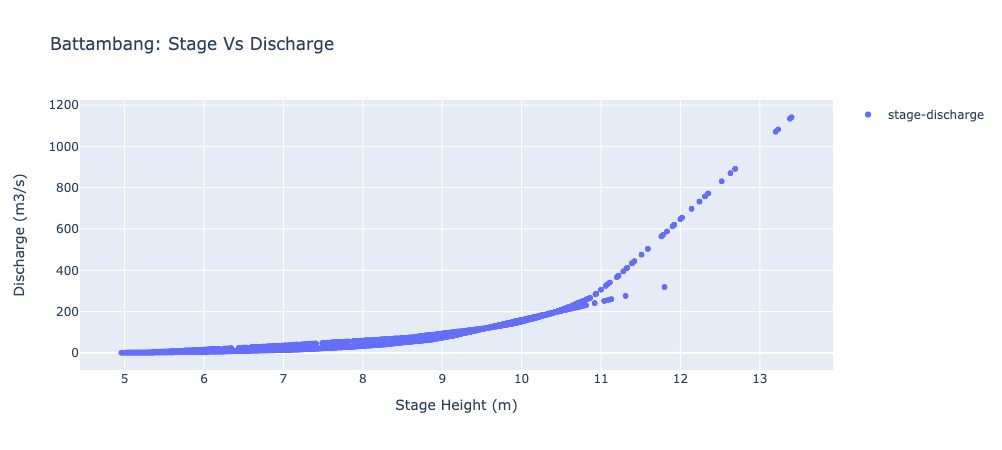

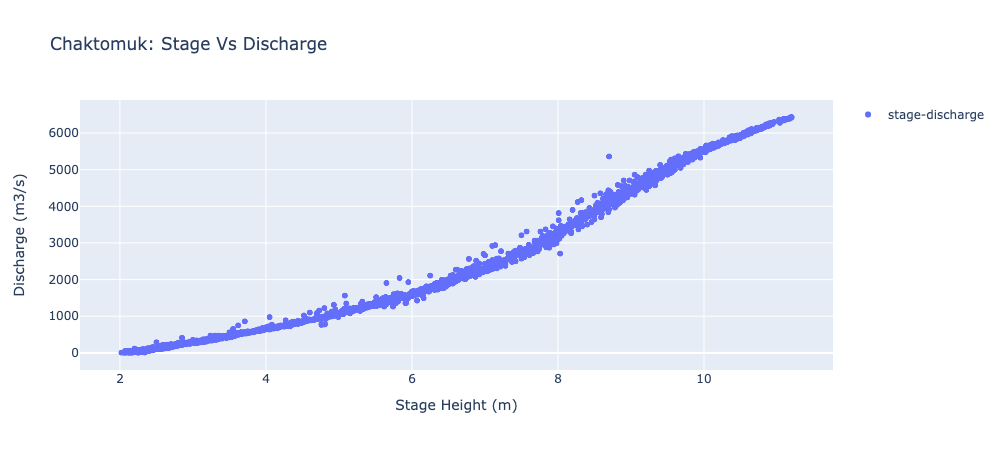

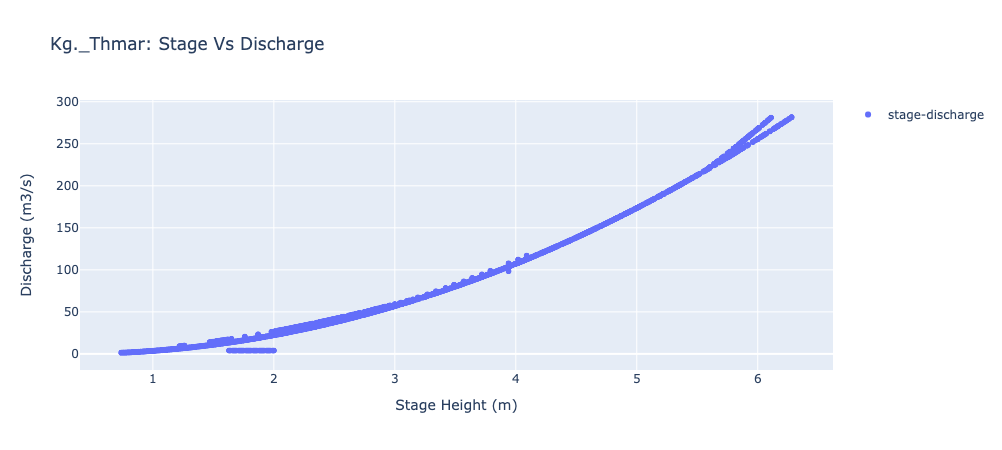

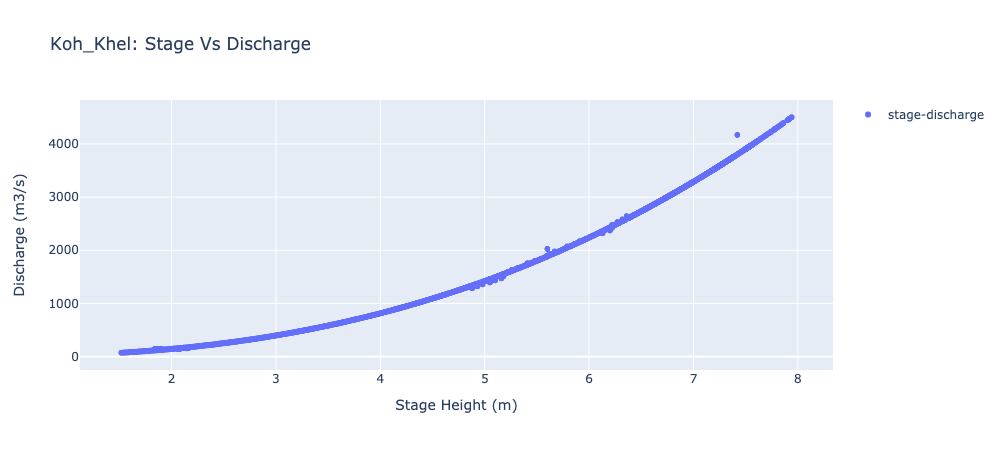

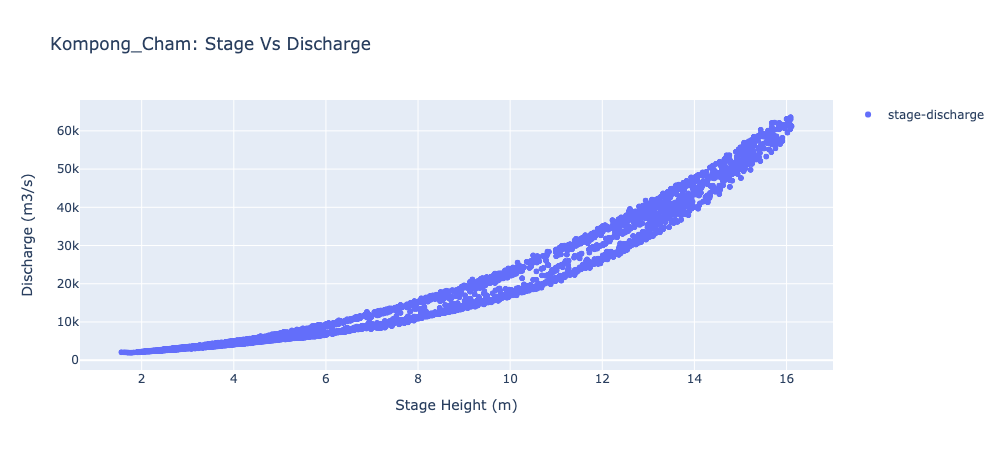

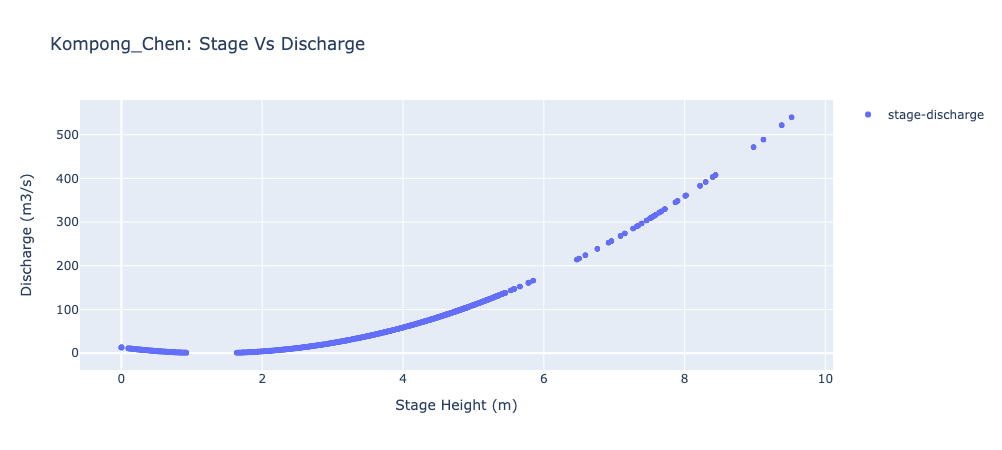

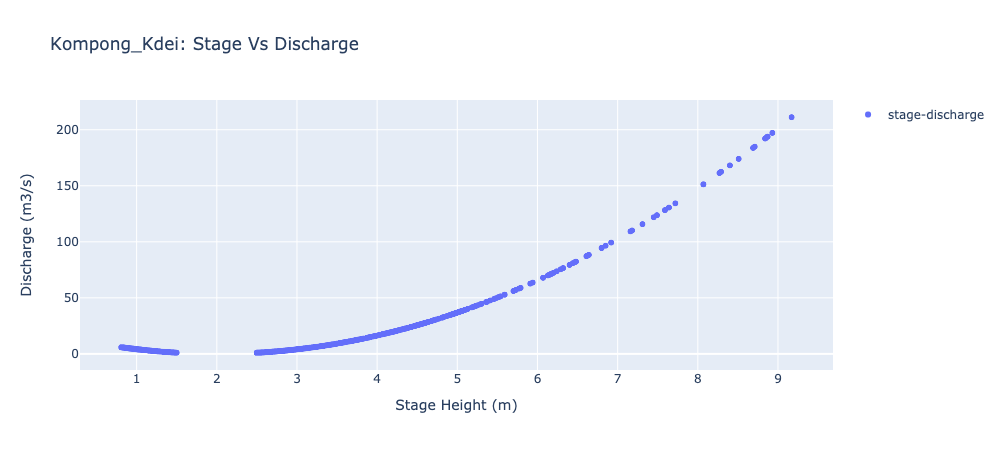

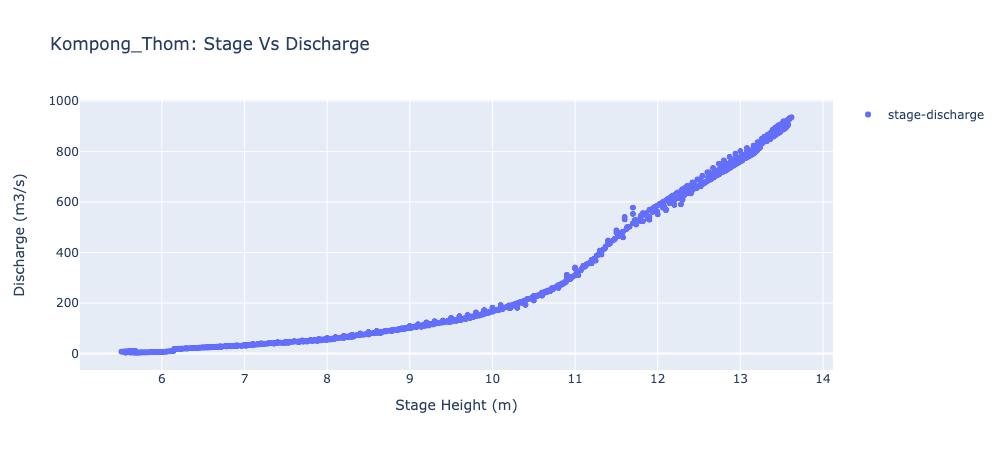

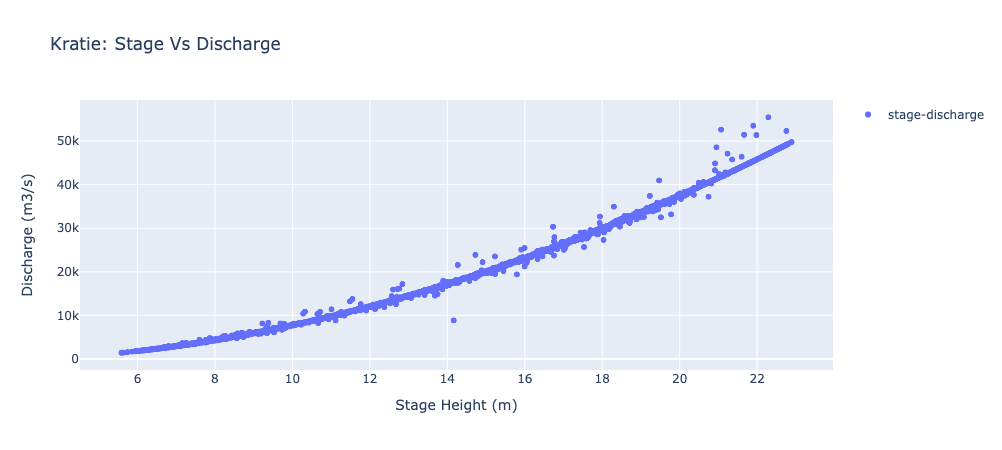

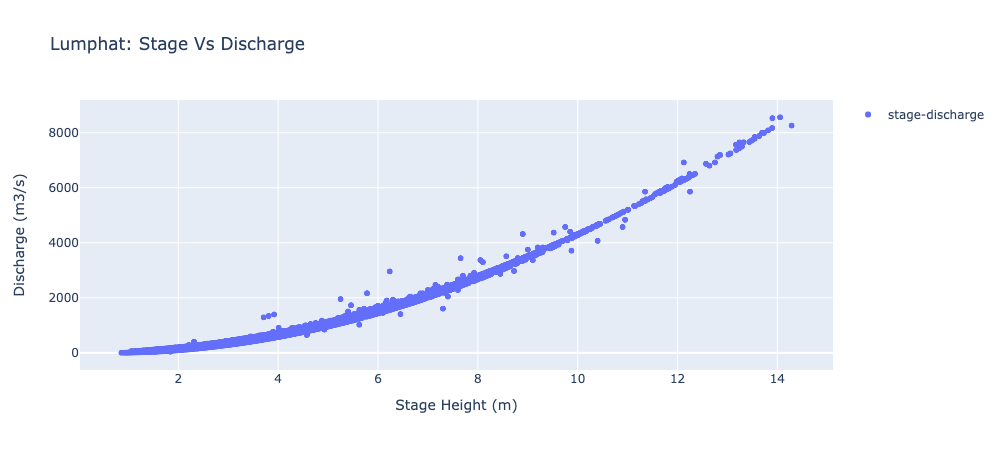

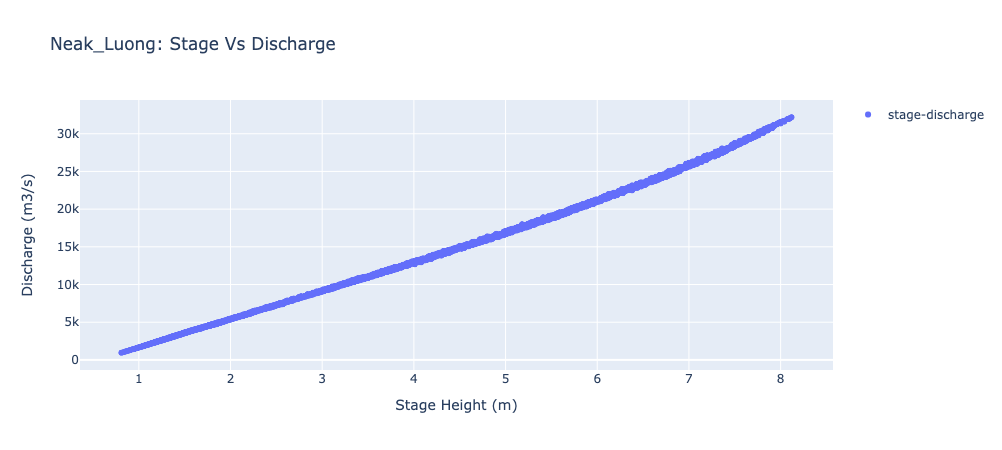

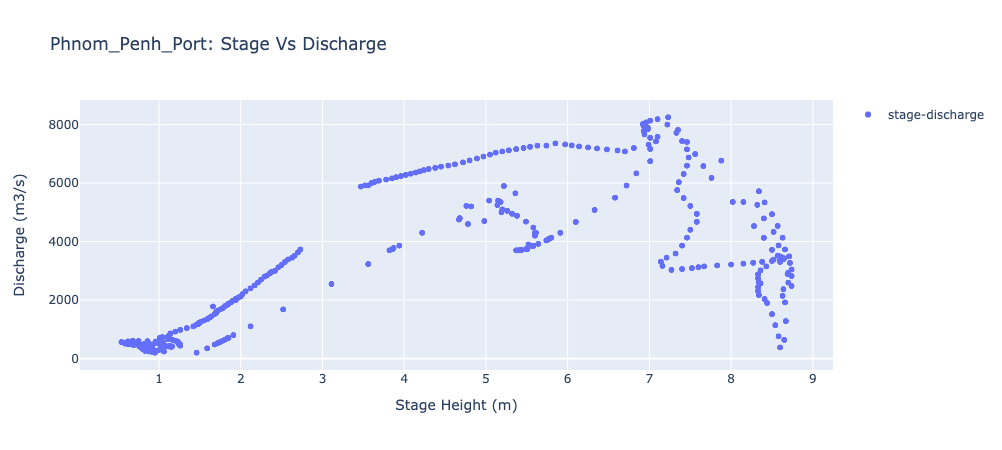

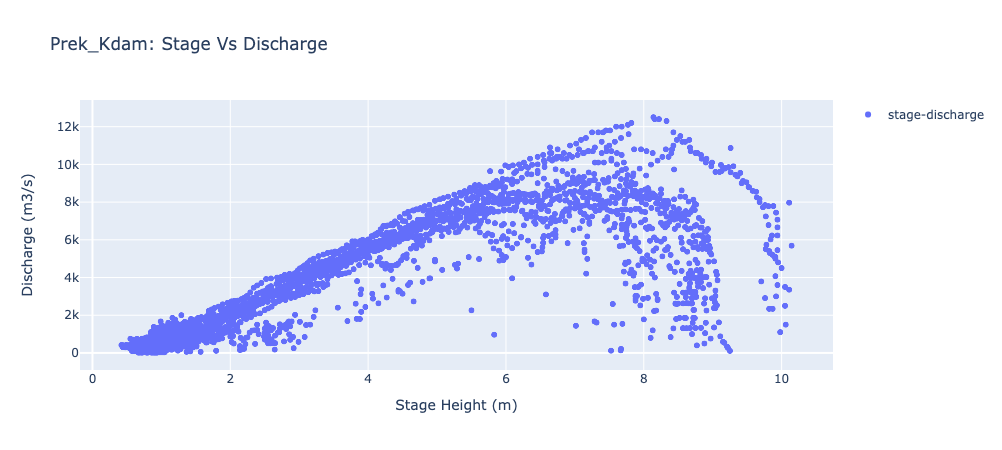

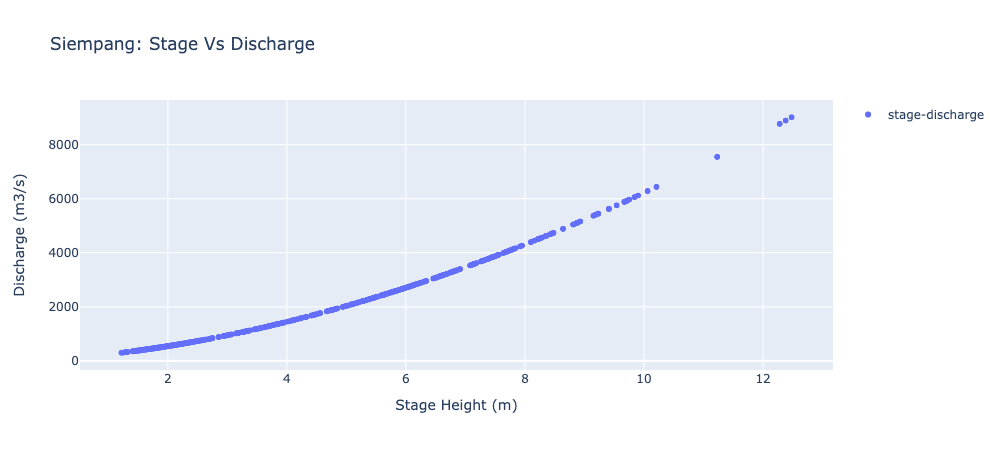

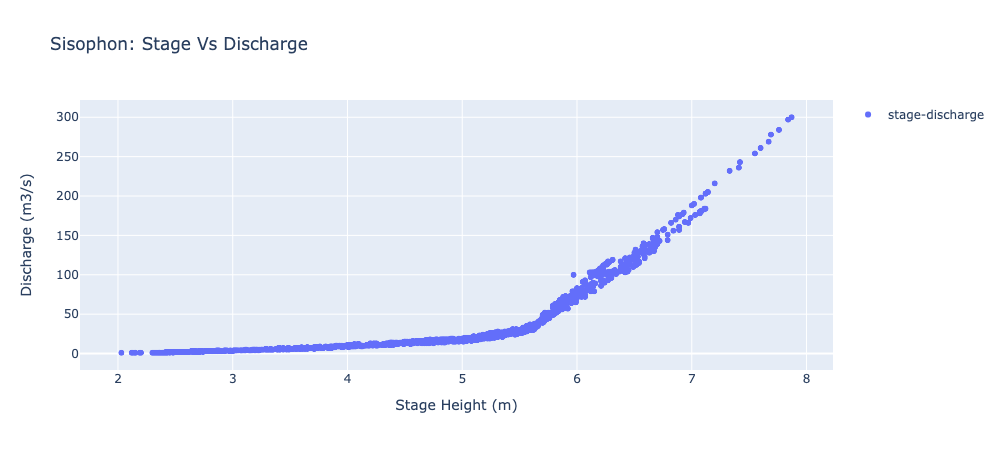

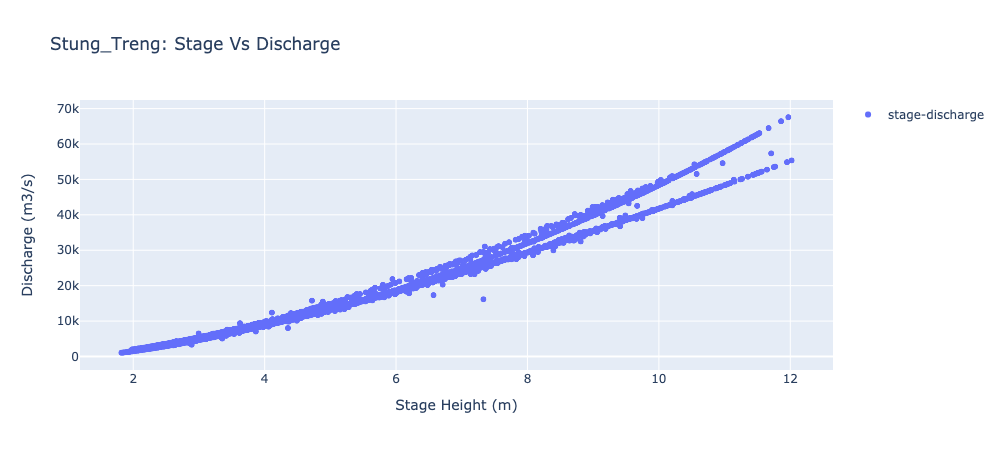

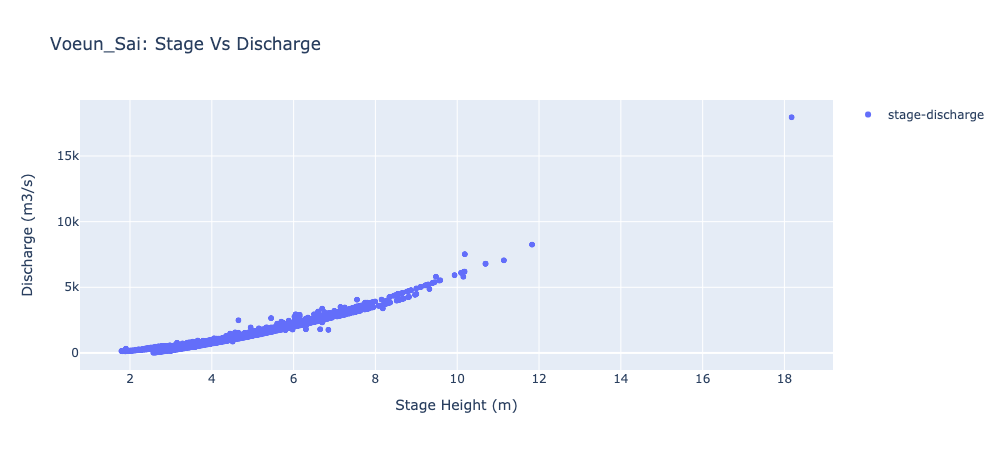

In [31]:
Path(f'{BASE_DIR}/plot_exports/stage_vs_discharge').mkdir(parents=True, exist_ok=True)

for _station in stations:
    
    station = _station['name']
    cutoff_time = _station['cutoff']
    
    df_discharge = pd.read_csv(f'{BASE_DIR}/pre_rating_curves/{station}/discharge.csv', index_col='datetime')
    df_stage = pd.read_csv(f'{BASE_DIR}/pre_rating_curves/{station}/stage.csv', index_col='datetime')

    df = pd.merge(df_stage, df_discharge, left_index=True, right_index=True, how='inner')
    df.index = pd.to_datetime(df.index)

    mask = (df.index >= cutoff_time)
    df = df.loc[mask]

    df.to_csv(f'{BASE_DIR}/pre_rating_curves/{station}/merged.csv', encoding='utf-8', index=True)

    dt_int = df.index.values.astype(float)

    scatter = go.Scattergl(x=df.stage,
                           y=df.discharge,
                           mode='markers',
                           name='stage-discharge',
                            # uncomment to view dates in colorscale
                            # or any attributes for that matter
#                            marker=dict(
#                                color=dt_int,
#                                colorbar=dict(title='Colorbar'),
#                                colorscale='Viridis',
#                            ),
                          )


    layout = go.Layout(title=f'{station}: Stage Vs Discharge',
                       xaxis=dict(title='Stage Height (m)'),
                       yaxis=dict(title='Discharge (m3/s)'),
                       showlegend=True)

    fig = go.Figure(data=[scatter], layout=layout)
    fig.show()

    fig.write_image(f'{BASE_DIR}/plot_exports/stage_vs_discharge/{station}_{cutoff_time}.png')


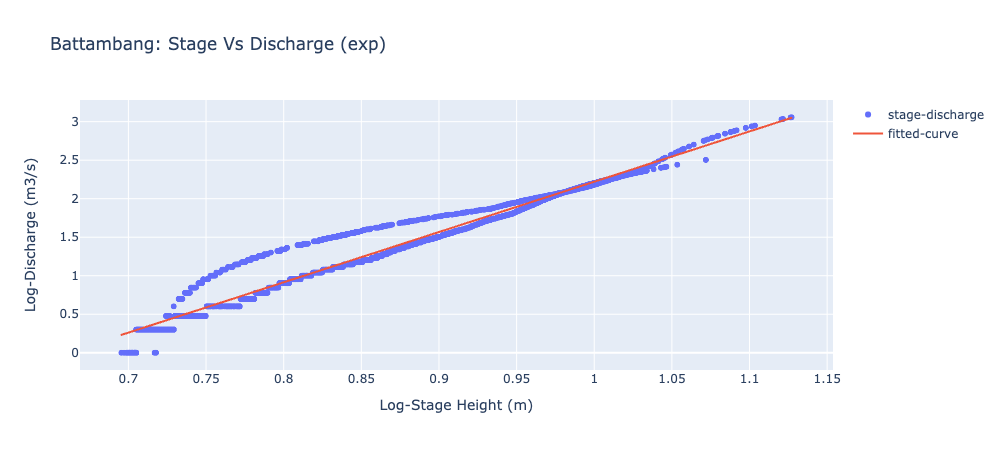

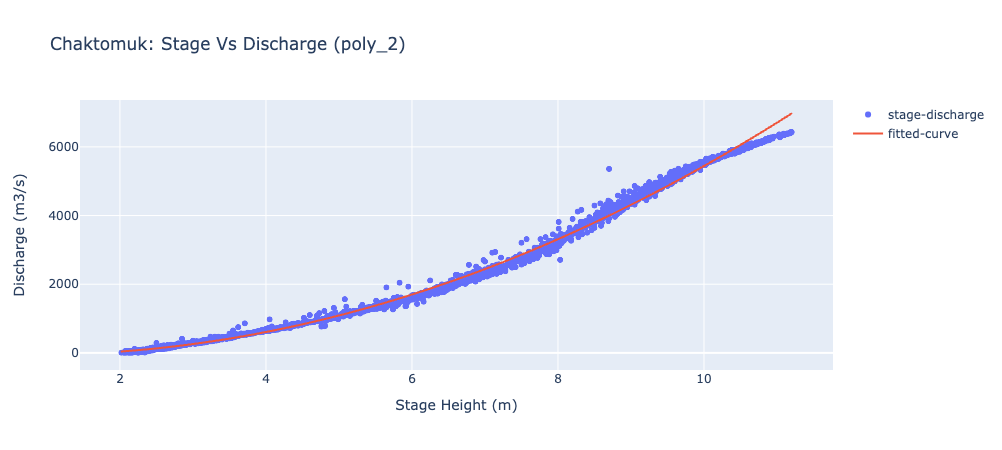

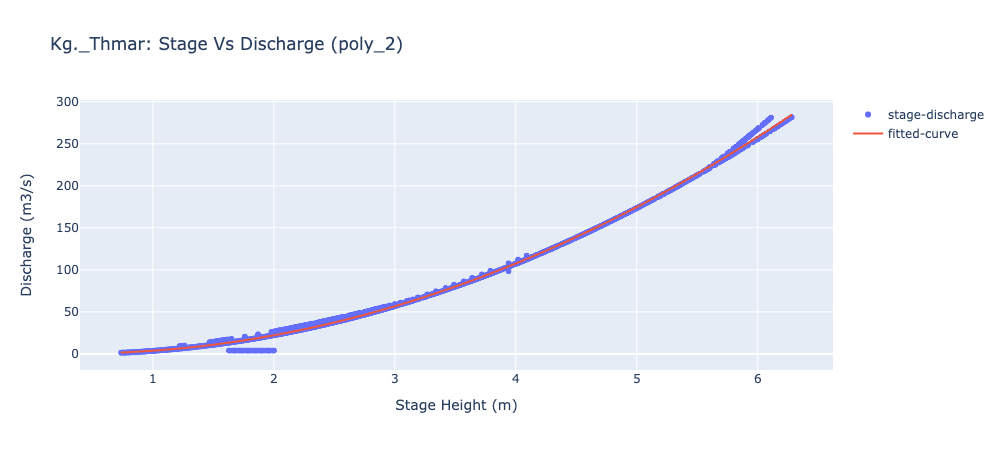

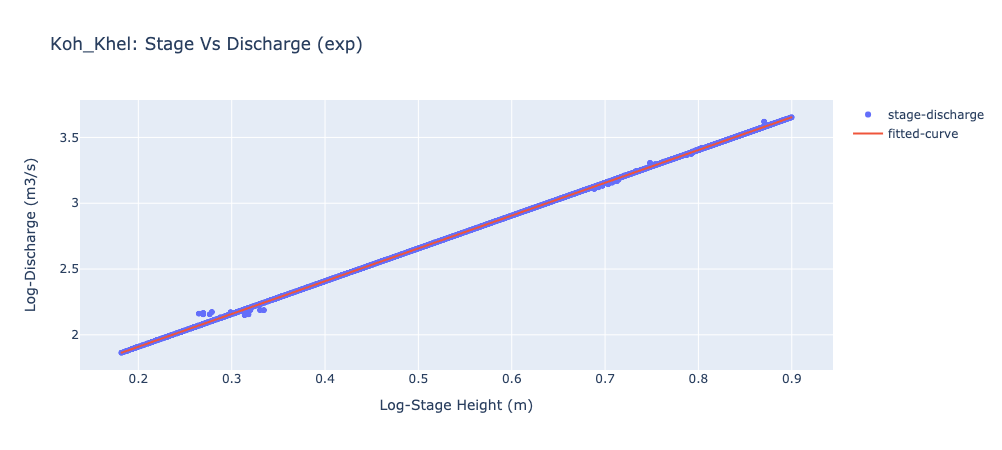

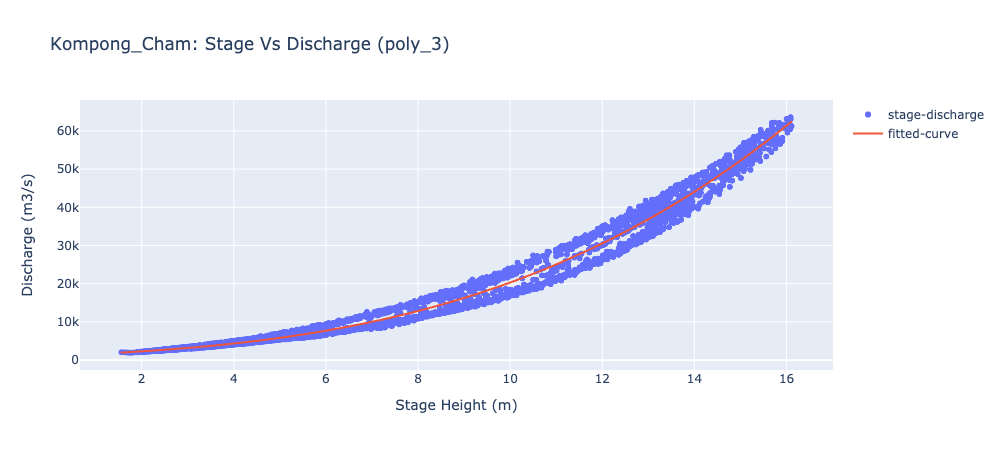

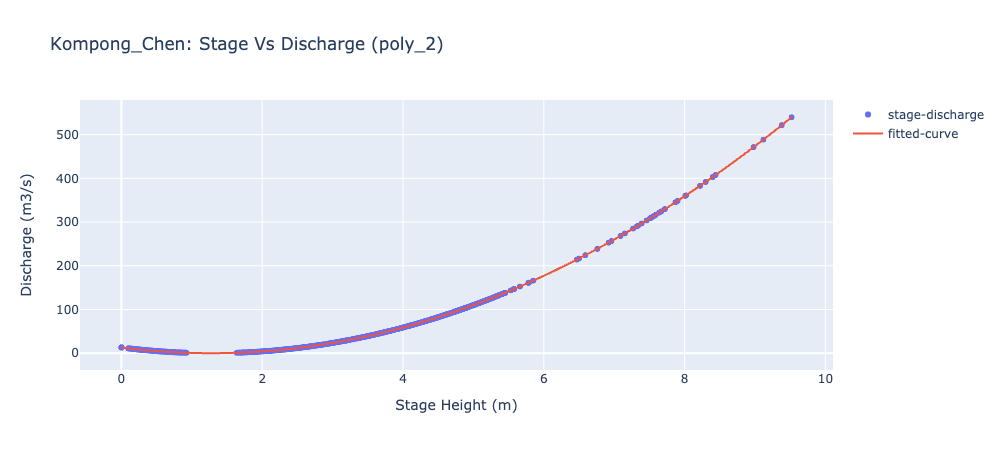

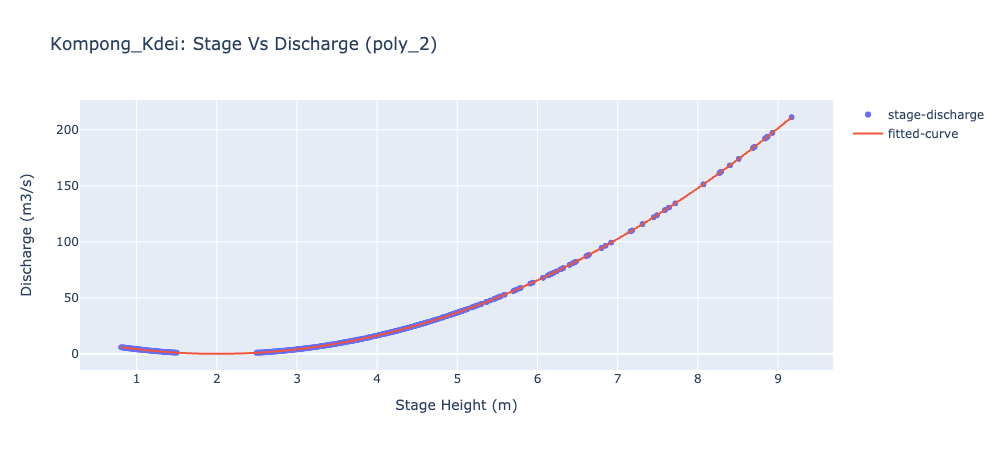

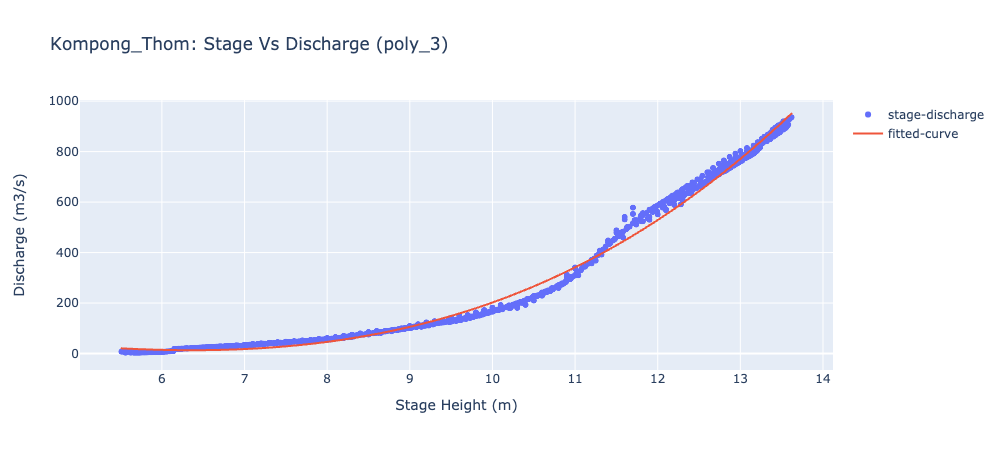

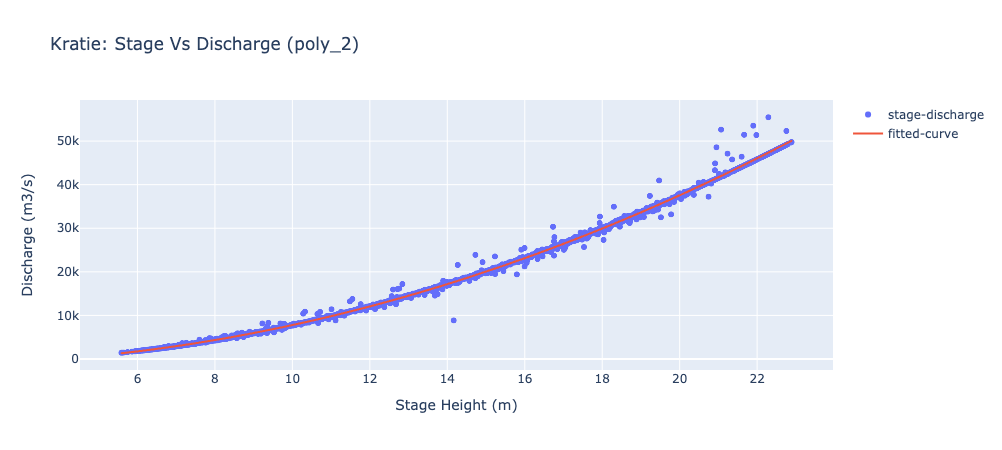

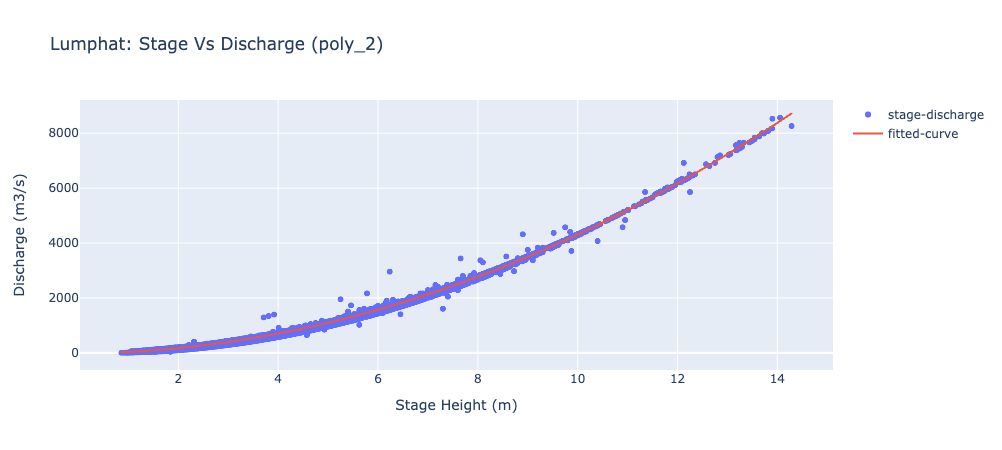

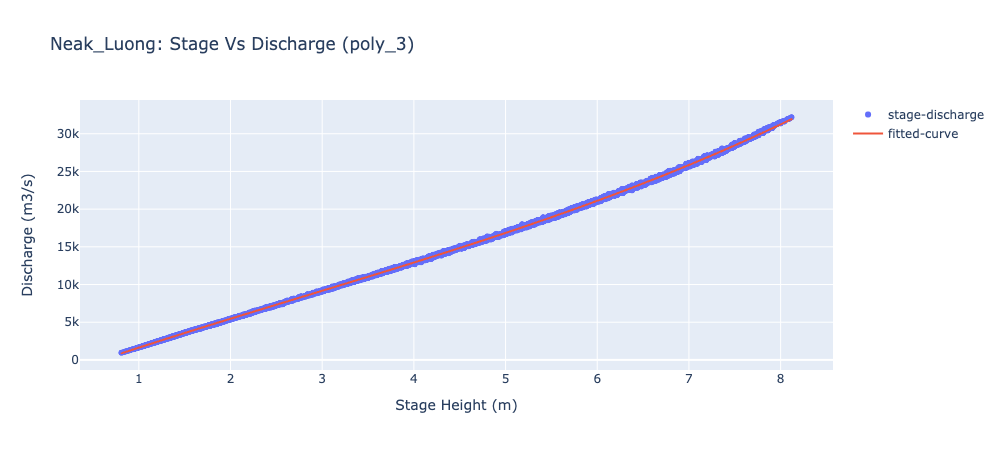

In [33]:
Path(f'{BASE_DIR}/rating_curves').mkdir(parents=True, exist_ok=True)
Path(f'{BASE_DIR}/plot_exports/rating_curves').mkdir(parents=True, exist_ok=True)

no_fit_stations = ['Phnom_Penh_Port', 'Prek_Kdam']

for _station in stations:
    station = _station['name']
    if station not in no_fit_stations:
        df_discharge = pd.read_csv(f'{BASE_DIR}/pre_rating_curves/{station}/discharge.csv', index_col='datetime')
        # to avoid inf problem with log
        df_discharge[df_discharge.discharge == 0.0] = 0.000001

        df_stage = pd.read_csv(f'{BASE_DIR}/pre_rating_curves/{station}/stage.csv', index_col='datetime')
        # to avoid inf problem with log
        df_stage[df_stage.stage == 0.0] = 0.000001

        df = pd.merge(df_stage, df_discharge, left_index=True, right_index=True, how='inner')
        df.index = pd.to_datetime(df.index)

        mask = df.index >= _station['cutoff']
        df = df.loc[mask]

        df['log_stage'] = np.log10(df.stage)
        df['log_discharge'] = np.log10(df.discharge)

        _min = df.log_stage.min()
        min_ = df.stage.min()

        _max = df.log_stage.max()
        max_ = df.stage.max()

        x = np.linspace(_min, _max)
        d = np.linspace(min_, max_)

        fopen = open(f'{BASE_DIR}/rating_curves/{station}_parameters.json', 'w+', encoding='utf-8')
        
        fit_eqn = _station['fitting']
        if fit_eqn == 'exp':
            # this is of the form
            # Q = Ad^(B) [Discharge (Q) = exponential relation to the depth (d)]
            # taking log and solving gives
            # log(Q) = B*log(d) + log(A)
            #     y  =      m*x + c

            # np recommends the polynomial.polyfit
#             coefficients = np.polyfit(df.log_stage, df.log_discharge, 1)
            coefficients = np.polynomial.polynomial.polyfit(df.log_stage, df.log_discharge, 1)
            # the order are reversed with polynomial.polyfit
            coefficients = coefficients[::-1]
            json_dump = {
                'm': coefficients[0],
                'c': coefficients[1],
            }
            scatter_eqn_x = df.log_stage
            scatter_eqn_y = df.log_discharge
            line_eqn_x = x
            line_eqn_y = json_dump['m'] * x + json_dump['c']
        
        elif fit_eqn == 'poly_2':
            # this is of the form
            # Q = a*d^2 + b*d + c
            coefficients = np.polynomial.polynomial.polyfit(df.stage, df.discharge, 2)
            # the order are reversed with polynomial.polyfit
            coefficients = coefficients[::-1]
            json_dump = {
                'a': coefficients[0],
                'b': coefficients[1],
                'c': coefficients[2],
            }
            scatter_eqn_x = df.stage
            scatter_eqn_y = df.discharge
            line_eqn_x = d
            line_eqn_y = np.multiply(json_dump['a'], np.power(d, 2)) + np.multiply(json_dump['b'], d) + json_dump['c']
        
        elif fit_eqn == 'poly_3':
            # this is of the form
            # Q = w*d^3 + x*d^2 + y*d + c
            coefficients = np.polynomial.polynomial.polyfit(df.stage, df.discharge, 3)
            # the order are reversed with polynomial.polyfit
            coefficients = coefficients[::-1]
            json_dump = {
                'w': coefficients[0],
                'x': coefficients[1],
                'y': coefficients[2],
                'c': coefficients[3],
            }
            scatter_eqn_x = df.stage
            scatter_eqn_y = df.discharge
            line_eqn_x = d
            line_eqn_y = np.multiply(json_dump['w'], np.power(d, 3)) + np.multiply(json_dump['x'], np.power(d, 2)) + np.multiply(json_dump['y'], d) + json_dump['c']
        
        # save the coefficients to reuse them later
        json.dump(json_dump, fopen, ensure_ascii=False, indent=4)
        fopen.close()

        # plotting
        scatter = go.Scattergl(x=scatter_eqn_x,
                               y=scatter_eqn_y,
                               mode='markers',
                               name='stage-discharge',
                               )

        fitting_line = go.Scattergl(x=line_eqn_x,
                                    y=line_eqn_y,
                                    mode='lines',
                                    name='fitted-curve',
                                    line=dict(width=2),
                               )
        

        layout = go.Layout(title=f'{station}: Stage Vs Discharge ({fit_eqn})',
                           xaxis=dict(title='Log-Stage Height (m)' if fit_eqn == 'exp' else 'Stage Height (m)'),
                           yaxis=dict(title='Log-Discharge (m3/s)' if fit_eqn == 'exp' else 'Discharge (m3/s)'),
                           showlegend=True)

        fig = go.Figure(data=[scatter, fitting_line], layout=layout)
        
        fig.write_image(f'{BASE_DIR}/plot_exports/rating_curves/{station}_{fit_eqn}.png')

        fig.show()